# Ejercicio 1_ Predicción de series temporales univariantes

# Parte I

In [20]:
#importing necessary packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import numpy as np 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf

from pycaret.regression import *

C:\Users\Leyre\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Leyre\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Leyre\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Importación de datos

In [2]:

import pandas as pd

url = 'https://drive.google.com/file/d/1g3UG_SWLEqn4rMuYCpTHqPlF0vnIDRDB/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df2 = pd.read_csv(path)

In [3]:
df2.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-19309700006,2019-05-13,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300.0,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,84,4409.16,63.0,16.64
1,INV-15347200002,2018-10-29,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600.0,Straight Rye Whiskies,214,GoAmericaGo Beverages LLC,27145,WhistlePig Old World 12YR,6,750,64.17,96.26,30,2887.80,22.5,5.94
2,INV-11117400006,2018-03-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1901200.0,Special Order Items,459,SURVILLE ENTERPRISES CORP,904955,1921 Tequila Reposado,6,750,26.50,39.75,12,477.00,9.0,2.38
3,INV-10206700012,2018-02-05,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300.0,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,12,566.88,9.0,2.38
4,INV-11743500040,2018-04-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600.0,Straight Rye Whiskies,306,MISSISSIPPI RIVER DISTIL,27027,Cody Road Rye,6,750,19.17,28.76,6,172.56,4.5,1.19


In [4]:
df2_ds = df2[['date','sale_dollars']] # selecting the needed columns

In [6]:
df2_ds=df2_ds.sort_index(axis=0)
df2_ds.tail(5)

,date,sale_dollars
50522,2019-12-09,1379.88
50523,2019-11-25,148.50
50524,2019-10-24,119.28
50525,2019-10-17,119.28
50526,2019-10-21,279.00


## Preprocesamiento de datos

In [8]:
aggregated=df2_ds.groupby('date',as_index=True).sum()
print(min(aggregated.index))
print(max(aggregated.index))

2018-01-03
2020-07-30


In [9]:
aggregated.index=pd.to_datetime(aggregated.index)

In [10]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['flag'] = pd.Series(np.where(df['date'] >= np.datetime64('2020-03-03'), 1, 0), index=df.index) #flag for COVID-19
    #df['rolling_mean_7'] = df['sale_dollars'].shift(7).rolling(window=7).mean()
    #df['lag_7'] = df['sale_dollars'].shift(7)
    #df['lag_15']=df['sale_dollars'].shift(15)
    #df['lag_last_year']=df['sale_dollars'].shift(52).rolling(window=15).mean()
  
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','flag','sale_dollars']]
    X.index=df.index
    return X

In [16]:
aggregated=create_features(aggregated)

C:\Users\Leyre\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [17]:
# split data into train-test set
train = aggregated[aggregated.index < '2020-06-15']
test = aggregated[aggregated.index >= '2020-06-15']

# check shape
train.shape, test.shape


((384, 9), (23, 9))

C:\Users\Leyre\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Leyre\anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Leyre\anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


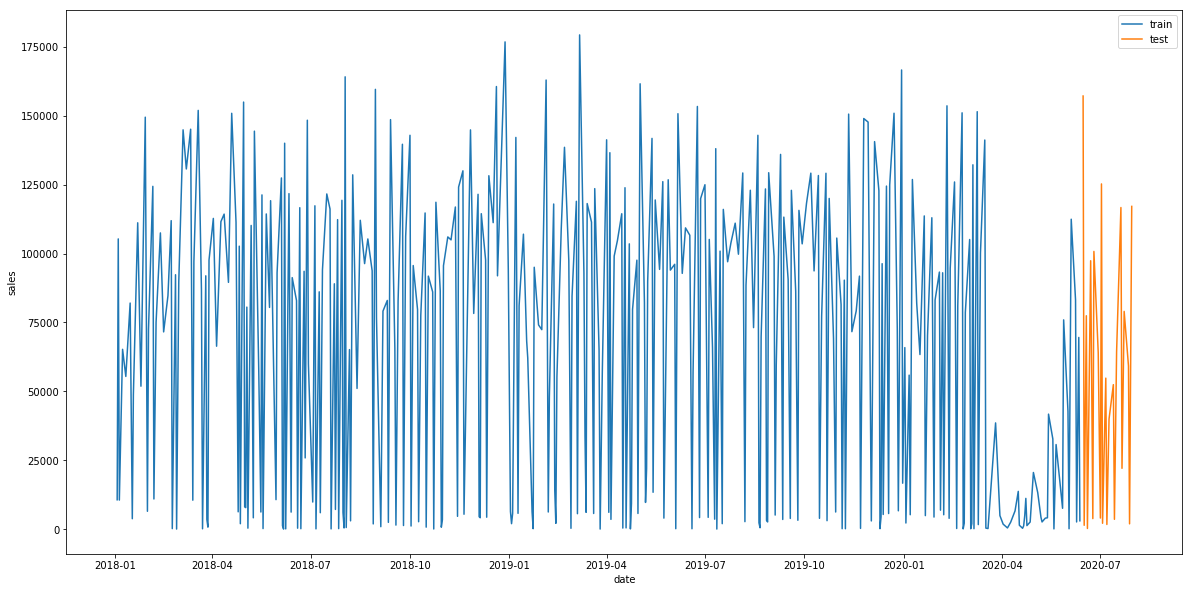

In [18]:
plt.figure(figsize=(20,10))
plt.xlabel('date')
plt.ylabel('sales')
plt.plot(train.index,train['sale_dollars'],label='train')
plt.plot(test.index,test['sale_dollars'],label='test')
plt.legend()
plt.show()

In [19]:
train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars
date,,,,,,,,,
2018-01-03,2,1,1,2018,3,3,1,0,10639.43
2018-01-04,3,1,1,2018,4,4,1,0,105307.95
2018-01-05,4,1,1,2018,5,5,1,0,10526.40
2018-01-08,0,1,1,2018,8,8,2,0,65236.68
2018-01-11,3,1,1,2018,11,11,2,0,55396.46


# Parte II

## Entrenamiento del modelo

In [21]:
reg = setup(data = train, 
             target = 'sale_dollars',
             numeric_imputation = 'mean',
             categorical_features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                                     'flag']  , 
            transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.1,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
             silent = True)

,Description,Value
0,session_id,4339
1,Target,sale_dollars
2,Original Data,"(384, 9)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(268, 141)"


In [22]:
best = compare_models(sort = 'R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,20151.0892,1036113887.8996,31336.2548,0.6178,1.4451,6.2846,0.1360
lightgbm,Light Gradient Boosting Machine,21523.4024,1164344147.4255,33148.6495,0.5752,1.5503,10.7308,0.0540
catboost,CatBoost Regressor,22617.3232,1235309134.3934,34193.3963,0.5391,1.5452,9.5637,0.7440
xgboost,Extreme Gradient Boosting,22011.9324,1250303180.8000,34410.6440,0.5342,1.6028,15.2849,0.6450
et,Extra Trees Regressor,27125.5402,1709153321.3625,40504.4943,0.3670,1.7972,18.5334,0.1440
dt,Decision Tree Regressor,27912.7796,1822326939.1918,42176.0295,0.3211,1.8712,12.3725,0.0110
ada,AdaBoost Regressor,32081.1581,2075294587.8871,44997.2272,0.2374,1.6605,14.6773,0.0280
knn,K Neighbors Regressor,38714.6100,2420232092.5538,48529.7103,0.1389,2.0954,50.7601,0.4920
lasso,Lasso Regression,54803.9055,3831688678.4000,61430.0961,-0.4056,2.3639,57.3449,0.4950
en,Elastic Net,54803.9055,3831688678.4000,61430.0961,-0.4056,2.3639,57.3449,0.5410


# Parte III

### Predicción y evaluación del modelo

##### Predicción con datos de entrenamiento

In [25]:
# generate predictions on the original dataset
predictions = predict_model(best, data=train)
predictions.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,Label
date,,,,,,,,,,
2018-01-03,2,1,1,2018,3,3,1,0,10639.43,5069.962280
2018-01-04,3,1,1,2018,4,4,1,0,105307.95,72145.494221
2018-01-05,4,1,1,2018,5,5,1,0,10526.40,12513.071082
2018-01-08,0,1,1,2018,8,8,2,0,65236.68,92600.187966
2018-01-11,3,1,1,2018,11,11,2,0,55396.46,72145.494221


In [29]:
import plotly.express as px
# line plot
fig = px.line(predictions, x=train.index, y=["sale_dollars", "Label"], template = 'plotly_dark')

# add a vertical rectange for test-set separation
fig.add_vrect(x0=min(train.index), x1=max(train.index), fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

##### Evaluación del modelo

In [23]:
predict_model(best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,21281.3349,1064614202.2315,32628.4263,0.6085,1.6615,10.7160
